# Разработка системы распознавания изображений в потоковом видео
## Часть 8: Аугментация изображений и изменения learning_rate
### Воропаев Роберт, 2020

In [1]:
class def_config:

    main_data_dir = "data/ADE20K_encoded/"
    callbacks_dir = "callbacks/"

    img_shape = 256
    classes_num = 17

    batch_size = 4
    epoch_num = 1
    train_coef = 0.001
    learning_rate = 0.0001

    last_activation = "sigmoid"
    loss_function = "categorical_crossentropy"

    gpu_memory_limit = 0.8
    cpu_threads_num = 4

    callbacks_monitor = "val_jaccard_coef"
    callbacks_data_format = "%m.%d_%H-%M"
    file_name = "DefName"
    
    is_load = False
    weight_path = None
    
    argparse_is_on = False
    
    
args = def_config()

In [25]:
%matplotlib inline

# System
import os
import sys
import datetime
import time

# Base
import numpy as np
import cv2
import random
from skimage.io import imshow, imread
from matplotlib import pyplot as plt

# Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout, BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger

# Preprocessing
from keras.utils import Sequence, to_categorical
from keras.utils.vis_utils import plot_model

# Backend
import tensorflow as tf
from keras import backend as K
from tensorflow.python.client import device_lib

# Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

In [11]:
main_data_dir = args.main_data_dir

train_dir = main_data_dir + "train/"
val_dir = main_data_dir + "val/"

img_train_dir = train_dir + "img/"
mask_train_dir = train_dir + "mask/"

img_val_dir = val_dir + "img/"
mask_val_dir = val_dir + "mask/"

# Callbacks

if def_config.argparse_is_on:
    file_name = sys.argv[0].split(".")[-2]
else:
    file_name = def_config.file_name
callbacks_dir = args.callbacks_dir

now = datetime.datetime.now()
callbacks_dir_name = file_name + now.strftime("_" + def_config.callbacks_data_format) + "/"


In [5]:
train_size = len(os.listdir(path=train_dir + "img/"))
val_size = len(os.listdir(path=val_dir + "img/"))
print("Train size: " + str(train_size))
print("Val size: " + str(val_size))

Train size: 6322
Val size: 623


In [7]:
img_shape = args.img_shape
batch_size = args.batch_size
classes_num = args.classes_num

epoch_num = args.epoch_num
train_coef = args.train_coef
learning_rate = args.learning_rate

loss_function = args.loss_function
last_activation = args.last_activation

In [362]:


def data_gen_iaa(img_dir, mask_dir, classes_num, batch_size):
    img_folder = img_dir
    mask_folder = mask_dir

    img_list = os.listdir(img_folder)
    random.shuffle(img_list)
    img_dir_size = len(img_list)

    for i in range(len(img_list)):
        img_list[i] = img_list[i].split(".")[0]  # отделяем имя от формата

    counter = 0
    while (True):
        img = np.zeros((batch_size, img_shape, img_shape, 3)).astype('float')
        mask = np.zeros((batch_size, img_shape, img_shape, classes_num)).astype("uint8")

        for i in range(counter, counter + batch_size):
            train_img = cv2.imread(img_folder + '/' + img_list[i] + ".jpg") 
            train_mask = cv2.imread(mask_folder + '/' + img_list[i] + ".png", cv2.IMREAD_GRAYSCALE)
            
            train_img = cv2.resize(train_img, (img_shape, img_shape))
            train_mask = cv2.resize(train_mask, (img_shape, img_shape), interpolation=cv2.INTER_NEAREST)
            
            # ImgAug
            seq = iaa.Sequential([
                iaa.Multiply(mul=(0.75, 1.25)),
                iaa.Affine(rotate=(-10, 10)),
                iaa.Fliplr(0.5)
            ])

            train_img = np.array([train_img])
            train_mask = np.array([train_mask])
            train_img, train_mask = seq(images=train_img, segmentation_maps=train_mask)
            train_img = train_img[0] / 255.
            train_mask = train_mask[0]

            train_mask = train_mask.reshape(img_shape, img_shape, 1)
            train_mask = to_categorical(train_mask, num_classes=classes_num)

            img[i - counter] = train_img
            mask[i - counter] = train_mask

        counter += batch_size

        if counter + batch_size >= img_dir_size:
            counter = 0
            random.shuffle(img_list)

        yield img, mask

In [363]:
train_gen = data_gen(img_train_dir, mask_train_dir, classes_num=classes_num, batch_size=batch_size)
val_gen = data_gen(img_val_dir, mask_val_dir, classes_num=classes_num, batch_size=batch_size)

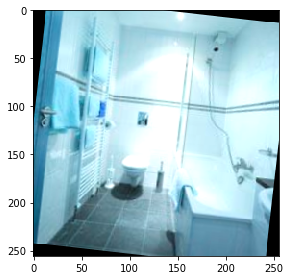

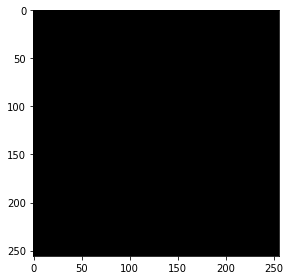

In [368]:
for img, mask in train_gen:
    imshow(img[0])
    plt.show()
    imshow(mask[0][:, :, 4])
    plt.show()
    break

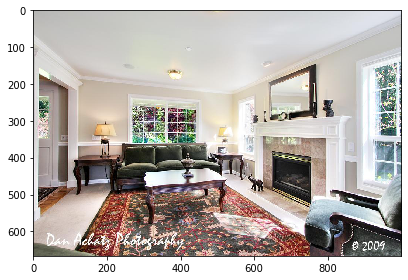

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


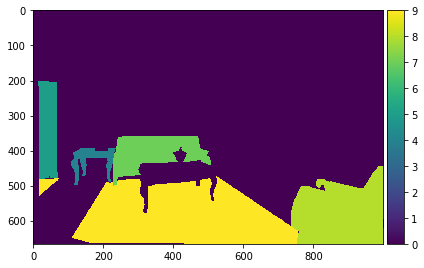

In [330]:
import imgaug.augmenters as iaa
import imgaug as ia

img = np.array([imread("data/ADE20K_encoded/train/img/00000672.jpg")])
mask = np.array([imread("data/ADE20K_encoded/train/mask/00000672.png")])

imshow(img[0])
plt.show()
imshow(mask[0])
plt.show()

# seq = iaa.Sequential([
#     iaa.Affine(rotate=(-90, 90))
# ])

# print(mask.dtype)
# imshow(img[0])
# plt.show()
# imshow(mask[0])
# plt.show()

# print(mask.shape)
# imga, maska = seq(images=img, segmentation_maps=mask[:, :, 0])
# maska = to_categorical(maska, num_classes=classes_num)
# imshow(imga[0])
# plt.show()
# imshow(maska[0][:, :, 9])

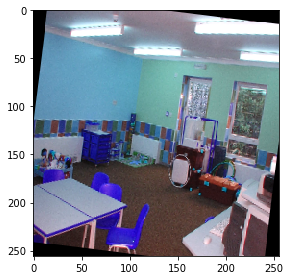

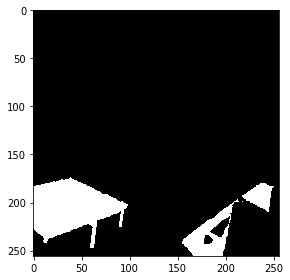

In [337]:
train_img = cv2.imread("data/ADE20K_encoded/train/img/00006624.jpg")# / 255.
train_img = cv2.resize(train_img, (img_shape, img_shape))

train_mask = cv2.imread("data/ADE20K_encoded/train/mask/00006624.png", cv2.IMREAD_GRAYSCALE)
train_mask = cv2.resize(train_mask, (img_shape, img_shape), interpolation=cv2.INTER_NEAREST)

seq = iaa.Sequential([
    iaa.Multiply(mul=(0.75, 1.25)),
    iaa.Affine(rotate=(-20, 20), mode=ia.ALL),
    iaa.Fliplr(0.5)
])


train_img = np.array([train_img])
train_mask = np.array([train_mask])
train_img, train_mask = seq(images=train_img, segmentation_maps=train_mask)
train_img = train_img[0] / 255.
train_mask = train_mask[0]

train_mask = train_mask.reshape(img_shape, img_shape, 1)
train_mask = to_categorical(train_mask, num_classes=classes_num)



imshow(train_img)
plt.show()
imshow(train_mask[:, :, 4])
plt.show()



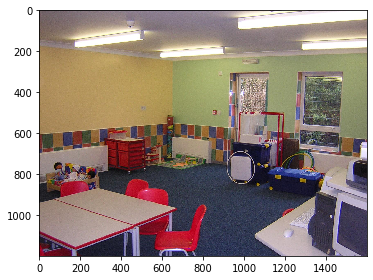

In [215]:
imshow(imread("data/ADE20K_encoded/train/img/00006624.jpg"))

### LR Scheduler 

In [1]:
def hyperbola(epoch, lr_start=1e-3, lr_stop=1e-5, max_epoch=300):
    # lr = lr_start/(1 + k * epoch)
    k = (lr_start / lr_stop - 1) / max_epoch
    return lr_start / (1 + k * epoch)

def exponential(epoch, lr_start=1e-3, lr_stop=1e-5, max_epoch=300):
    #llr_start * e^(−k * epoch)
    k = np.log(lr_start / lr_stop) / max_epoch
    return lr_start * np.exp(-k * epoch)

In [ ]:
x = np.arange(1, epoch + 1, 1)

plt.plot(x, time_based(x), label="hyper")
plt.plot(x, exponential_decay(x), label="exp")
plt.legend()
plt.show()